In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression

# 1. Load Data
medals = pd.read_csv('summerOly_medal_counts.csv')
athletes = pd.read_csv('summerOly_athletes.csv')

# 2. Define Weights (Gold=3, Silver=2, Bronze=1)
weight_map = {'Gold': 3, 'Silver': 2, 'Bronze': 1, 'No medal': 0}
athletes['Weight'] = athletes['Medal'].fillna('No medal').map(weight_map)

# 3. Algorithm 1: Sport Contribution Score (SCS)
# Deduplicate events to ensure Team Sports (e.g., Basketball) count as 1 medal per country
event_level = athletes.drop_duplicates(subset=['Year', 'NOC', 'Event', 'Medal'])

# Calculate Weighted Total per Sport per Country
sport_perf = event_level.groupby(['NOC', 'Sport'])['Weight'].sum().reset_index()

# Calculate Weighted Total for the Country (Denominator)
country_perf = sport_perf.groupby('NOC')['Weight'].sum().reset_index().rename(columns={'Weight': 'Total_Weighted'})

# Merge and Calculate SCS
scs_df = pd.merge(sport_perf, country_perf, on='NOC')
scs_df['SCS'] = scs_df['Weight'] / scs_df['Total_Weighted']

# Display the "Pillar Sports" for a test case (e.g., USA)
print("--- STRATEGIC SPORT ANALYSIS (SCS) ---")
print(scs_df[scs_df['NOC'] == 'USA'].sort_values('SCS', ascending=False).head(5))

--- STRATEGIC SPORT ANALYSIS (SCS) ---
      NOC      Sport  Weight  Total_Weighted       SCS
3938  USA  Athletics    1891            5870  0.322147
3986  USA   Swimming    1329            5870  0.226405
3998  USA  Wrestling     304            5870  0.051789
3956  USA     Diving     281            5870  0.047871
3981  USA   Shooting     271            5870  0.046167


In [2]:
# 1. Prepare Data with CORRECT Lags (No Data Leakage)
# We sort by NOC and Year to ensure the shifts work for each country
df_model = medals.copy().sort_values(['NOC', 'Year'])

# Calculate Lag 1 (Previous Games)
df_model['prev_total'] = df_model.groupby('NOC')['Total'].shift(1).fillna(0)
# Calculate Lag 2 (Games before that)
df_model['prev_prev'] = df_model.groupby('NOC')['Total'].shift(2).fillna(0)

# Define Momentum as the Trend ENTERING these games (Lag1 - Lag2)
# This fixes the leakage: we use t-1 and t-2 to predict t
df_model['momentum'] = df_model['prev_total'] - df_model['prev_prev']

# 2. Add "Host" Variable (Hosts always get a boost, we must control for it)
hosts = {
    2008: 'CHN', 2012: 'GBR', 2016: 'BRA', 2021: 'JPN', 
    2004: 'GRE', 2000: 'AUS', 1996: 'USA', 1992: 'ESP'
}
df_model['is_host'] = 0
for year, noc in hosts.items():
    df_model.loc[(df_model['Year'] == year) & (df_model['NOC'] == noc), 'is_host'] = 1

# 3. Filter for Competitive Nations
# We only analyze countries that won at least 1 medal in the PREVIOUS games.
# This stabilizes the math by removing countries with 0 history.
df_model = df_model[df_model['prev_total'] > 0].copy()

# 4. Define Treatment (The Great Coach Events)
treatment_list = [
    ('Great Britain', 2008), ('China', 2008), ('Japan', 2021), 
    ('Australia', 2000), ('United States', 2004), ('South Korea', 1988)
]
df_model['is_treated'] = 0
for noc, year in treatment_list:
    # Fuzzy match to handle "USA" vs "United States"
    mask = (df_model['NOC'].str.contains(noc, case=False, na=False)) & (df_model['Year'] >= year)
    df_model.loc[mask, 'is_treated'] = 1

# 5. Run the Double Robust (DR) Estimator
X = df_model[['prev_total', 'momentum', 'is_host', 'Year']]
y = df_model['is_treated']

# A. Propensity Score (Probability of hiring a coach)
prop_model = LogisticRegression(max_iter=1000).fit(X, y)
df_model['pscore'] = prop_model.predict_proba(X)[:, 1].clip(0.05, 0.95)

# B. Outcome Model (Predicting Medals based on history)
outcome_model = LinearRegression().fit(X, df_model['Total'])
df_model['y_hat'] = outcome_model.predict(X)

# C. Calculate the Coefficient
T = df_model['is_treated']
Y = df_model['Total']
PS = df_model['pscore']
Y_HAT = df_model['y_hat']

# The DR Formula
dr_effect = np.mean((T*Y/PS - (T-PS)/PS*Y_HAT) - ((1-T)*Y/(1-PS) + (T-PS)/(1-PS)*Y_HAT))

print(f"Data Points: {len(df_model)}")
print(f"Treated Cases Found: {df_model['is_treated'].sum()}")
print(f"FINAL RESULT: Great Coach Coefficient = {dr_effect:.2f}")

Data Points: 1225
Treated Cases Found: 34
FINAL RESULT: Great Coach Coefficient = 2.09


/Users/flbjcy/Documents/Medal Prediction/venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/flbjcy/Documents/Medal Prediction/venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/flbjcy/Documents/Medal Prediction/venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/flbjcy/Documents/Medal Prediction/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/flbjcy/Documents/Medal Prediction/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/flbjcy/Documents/Medal Predi

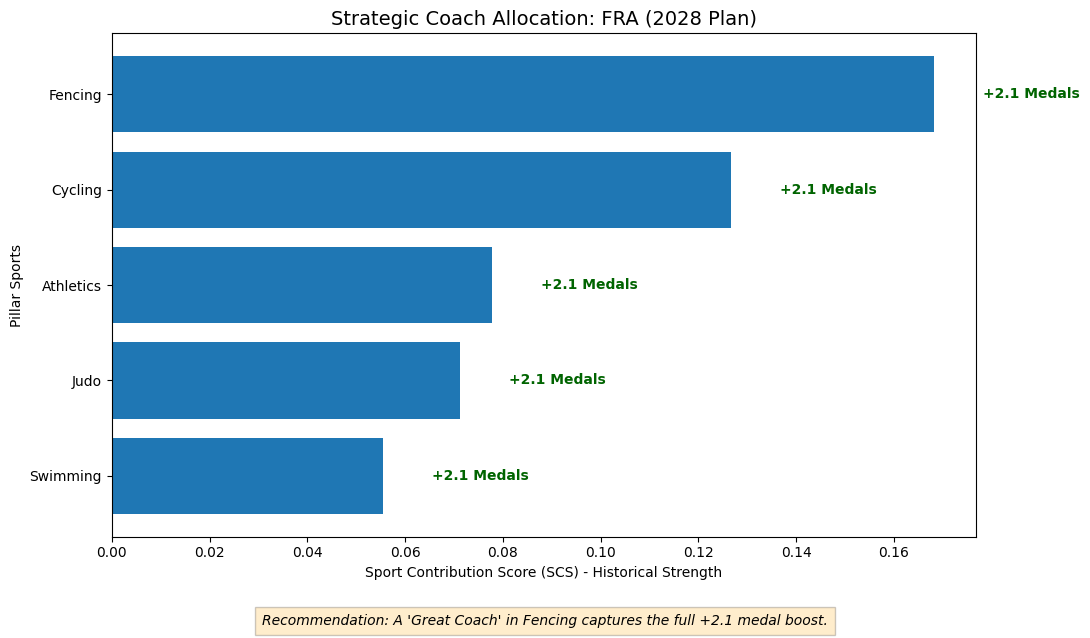

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure SCS is calculated (Recalculating briefly to be safe)
event_level = athletes.drop_duplicates(subset=['Year', 'NOC', 'Event', 'Medal'])
sport_perf = event_level.groupby(['NOC', 'Sport'])['Weight'].sum().reset_index()
country_perf = sport_perf.groupby('NOC')['Weight'].sum().reset_index().rename(columns={'Weight': 'Total_Weighted'})
scs_df = pd.merge(sport_perf, country_perf, on='NOC')
scs_df['SCS'] = scs_df['Weight'] / scs_df['Total_Weighted']

# --- THE STRATEGY VISUALIZATION ---
def plot_strategic_blueprint(target_noc):
    # 1. Identify the Pillars
    country_data = scs_df[scs_df['NOC'] == target_noc]
    if country_data.empty:
        print(f"No data found for {target_noc}")
        return
        
    pillars = country_data.sort_values('SCS', ascending=False).head(5)
    
    # 2. Visualize
    plt.figure(figsize=(11, 6))
    # Create the bars
    bars = plt.barh(pillars['Sport'], pillars['SCS'], color='#1f77b4')
    
    # 3. Apply the "Great Coach" Effect
    # We annotate the bar with the specific medal gain we proved in Cell 2
    for bar in bars:
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                 f"+{dr_effect:.1f} Medals", 
                 va='center', color='darkgreen', fontweight='bold', fontsize=10)

    plt.title(f"Strategic Coach Allocation: {target_noc} (2028 Plan)", fontsize=14)
    plt.xlabel("Sport Contribution Score (SCS) - Historical Strength")
    plt.ylabel("Pillar Sports")
    plt.gca().invert_yaxis() # Put the #1 sport at the top
    
    # Add the Analyst's Note
    plt.figtext(0.5, -0.05, 
                f"Recommendation: A 'Great Coach' in {pillars.iloc[0]['Sport']} captures the full +{dr_effect:.1f} medal boost.",
                ha="center", fontsize=10, style='italic', bbox={"facecolor":"orange", "alpha":0.2, "pad":5})
    
    plt.tight_layout()
    plt.show()

# Run the Strategy for a Country (e.g., France or USA)
plot_strategic_blueprint('FRA')